## Table of Contents
- Import
- Load Data
- Pre-process Data
    - 1: Unify year notation
    - 2: Extract ethnicity
    - 3: Actor name and page link
    - 4: Add Wikidata ID, Rotten Tomatoes score and number of reviews
    - 5: Masculinity and femininity score per summary with Empath library
    - 6: Merge character and Movie DF
- Simple analysis of movie metadata
    - 1: Number of movies/actors for which we have data in each category
    - 2: Ethnicity availability
    - 3: Combined analysis of Movies
    - 4: Combinatory analysis of character information
    - 5: Combined analysis of characters and movies
    - 6: Temporal analysis
    - 7: Rotten Tomatoes score    
    - 8: Simple ethnicity display for Men in Black and Pulp fiction

# Import

In [1]:
%%capture
!pip install mkwikidata;
!pip install "requests>=2.20.1";
!pip install "mwparserfromhell>=0.5.0";
!pip install empath

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
import pickle
import time 
from pathlib import Path
import mkwikidata
import requests
from empath import Empath

In [2]:
DATA_FOLDER = 'movieData/'
movie_metadata_path = DATA_FOLDER+"movie.metadata.tsv"
character_metadata_path = DATA_FOLDER+"character.metadata.tsv"
name_clusters_path = DATA_FOLDER+"name.clusters.txt"
plot_summaries_path = DATA_FOLDER+"plot_summaries.txt"
tvtropes_clusters_path = DATA_FOLDER+"tvtropes.clusters.txt"

# Load Data

In [ ]:
#load movies dataset
movieDF = pd.read_csv(movie_metadata_path, sep="\t", header=None, names=['Wikipedia Movie ID', 'Freebase movie ID', 'Movie name',
                    'Year','Box office revenue', 'Runtime', 'Language', 'Country', 'Genre'])
movieDF.head(5)

,Wikipedia Movie ID,Freebase movie ID,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [ ]:
#load characters dataset
characterDF = pd.read_csv(character_metadata_path, sep="\t", header=None, names=['Wikipedia Movie ID', 'Freebase movie ID','Movie date', 'Character Name',
                    'DOB','Gender', 'Height', 'ethnicity ID', 'Actor name', 'Actor age at release','Freebase character map', 'unknown param1', 'Freebase wikidata actor page'])
characterDF.head()

,Wikipedia Movie ID,Freebase movie ID,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,Freebase character map,unknown param1,Freebase wikidata actor page
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
#load plot_summuries data
df_summaries = pd.read_csv('movieData/plot_summaries.txt',sep='\t')
df_summaries.columns = ['Wikipedia movie ID', 'Summary']
df_summaries.head()

,Wikipedia movie ID,Summary
0,31186339,The nation of Panem consists of a wealthy Capi...
1,20663735,Poovalli Induchoodan is sentenced for six yea...
2,2231378,"The Lemon Drop Kid , a New York City swindler,..."
3,595909,Seventh-day Adventist Church pastor Michael Ch...
4,5272176,The president is on his way to give a speech. ...


# Pre-process Data

### 1: Unify year notation

In [6]:
#Unify year notation
movieDF['Year']= movieDF['Year'].dropna().apply(lambda x: parse(x).year if(1887<parse(x).year<2018) else pd.NA)

### 2: Extract ethnicity

In [7]:
#try to open ethnicity dictonnary from saved file, otherwise create it and load it
pathEthnicityDict, pathEthnicityDF = Path('processedData/myEthnicitydict.pickle'), Path('processedData/ethnicityDF.pkl')
if pathEthnicityDict.is_file() and pathEthnicityDF.is_file():
    myEthnicitydict = pickle.load(open(pathEthnicityDict, 'rb'))
    ethnicityDF = pd.read_pickle(pathEthnicityDF)
    ethnicityDF.columns = ethnicityDF.iloc[0]
    ethnicityDF = ethnicityDF[1:]
    loadedEthnicity = True
else :
    # Create ethnicity data frame with ethnicity freebase ID, ethnicity name, and number of actor per ethnicity
    ethnicityDF = pd.DataFrame(characterDF.groupby(by = ['ethnicity ID']).size()[characterDF.groupby(by = ['ethnicity ID']).size() > -1], columns=['Number'])
    ethnicityDF['Freebase ID'] = ethnicityDF.index
    ethnicityDict = {}
    loadedEthnicity = False

In [ ]:
#Run a single query with (almost) all ethnicity from the freebase ID
if not loadedEthnicity :
    query = """
    SELECT ?item ?freebaseID ?name WHERE {
      ?item p:P646 [ps:P646 ?freebaseID]. #get the freebaseID
      ?item rdfs:label ?name.             #get the name of the enthnic group
      ?item p:P31 [ps:P31 wd:Q41710].     #get only the items whose "instance of" is "ethnic group"
      filter(lang(?name) = "en")          #get the names in english
    }
    """
    queryResult = mkwikidata.run_query(query, params={ })

    #Store the results in a dict for easy retrival
    ethnicityDict = {}
    for x in queryResult["results"]["bindings"]:
        ethnicityDict[x["freebaseID"]["value"]] = x["name"]["value"]

In [9]:
# Complete the dataset with the lacking ethnicity name, run multiple time until convergence 
if not loadedEthnicity :
    queryBase = """
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

    SELECT  ?s ?sLabel ?p  ?o ?oLabel WHERE {
     ?s wdt:P646 "TO REPLACE" 

       SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
       }
     }
    """

    failure, prevousFailure = 0, -1
    while (failure != previousFailure):
        failure = 0 
        for index, row in ethnicityDF.iterrows():
            if not row['Freebase ID'] in ethnicityDict:
                query = queryBase.replace('TO REPLACE', row['Freebase ID'])
                i = 0
                while(i < 5):
                    i+=1
                    try :
                        time.sleep(0.001) #to avoid to be block because of multiple successive request
                        query_result = mkwikidata.run_query(query, params={ })
                        data = [x["sLabel"]["value"] for x in query_result["results"]["bindings"]]
                        if(len(data)):
                            ethnicityDict[row['Freebase ID']] = data[0]
                            i = 6
                    except: pass
                if not row['Freebase ID'] in ethnicityDict:        
                    failure += 1

        print('How many time did we fail ? ', failure)
        previousFailure = failure
    
    #fill the missing values with Na's after we converged
    for index, row in ethnicityDF.iterrows():
        if not row['Freebase ID'] in ethnicityDict:
            ethnicityDict[row['Freebase ID']] = pd.NA

    #save the dictionnary
    with open('myEthnicitydict.pickle', 'wb') as file:
        pickle.dump(ethnicityDict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
#save the dictionnary and the ethnicity DF
if not loadedEthnicity :
    pickle.dump(ethnicityDict, open(pathEthnicityDict, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    ethnicityDF['Name'] = ethnicityDF['Freebase ID'].apply(lambda x : ethnicityDict[x]) #complete the DF with the found ethnicity
    ethnicityDF.sort_values(['Number'], ascending=False)
    ethnicityDF.to_pickle(pathEthnicityDF)

In [11]:
#Display ethnicty DF
ethnicityDF

ethnicity ID,Number,Freebase ID,Name
/m/01267,10,/m/01267,Albanians
/m/012c1l,141,/m/012c1l,French Canadians
/m/012f86,32,/m/012f86,Ukrainians
/m/012fh,1,/m/012fh,Afrikaners
/m/01336l,224,/m/01336l,Asian Americans
...,...,...,...
/m/0j4w_,43,/m/0j4w_,Croats
/m/0j6x8,43,/m/0j6x8,Aboriginal Australians
/m/0x67,10159,/m/0x67,African Americans
/m/0xff,5,/m/0xff,Arabs


In [12]:
#Add Ethnicity name to characterDF based on ethnicityDF
characterDF['Ethnicity'] = pd.NA
characterDF['Ethnicity'] = characterDF['ethnicity ID'].dropna().apply(lambda x : ethnicityDF.loc[x].Name)
characterDF.head(5)

,Wikipedia Movie ID,Freebase movie ID,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,Freebase character map,unknown param1,Freebase wikidata actor page,Ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


### 3: Actor name and page link

In [13]:
#extract one freebase link for actor name and page   
queryBase = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>

SELECT  ?s ?sLabel ?p  ?o ?oLabel WHERE {
    ?s wdt:P646 "TO REPLACE" 

    SERVICE wikibase:label {
    bd:serviceParam wikibase:language "en" .
    }
    }
"""

#extract third link of the dataframe
query = queryBase.replace('TO REPLACE', characterDF['Freebase wikidata actor page'][3])
#Run the query to wikidata
query_result = mkwikidata.run_query(query, params={ })
#Process and display the returned data 
data = [[x["sLabel"]["value"], x["s"]["value"]] for x in query_result["results"]["bindings"]]
print('Name : \"%s\", actor\'s URL to wikidata \"%s\"' %(data[0][0],data[0][1]))

Name : "Jason Statham", actor's URL to wikidata "http://www.wikidata.org/entity/Q169963"


We'll see further in this notebook that we already always have the actor's name, and the URL to the wikidata page, don't seem relevant to us. Thus we won't exploit any further this entry.

### 4: Add Wikidata ID, Rotten Tomatoes score and number of reviews

In [14]:
path_compl_data = Path('processedData/complementary_data.tsv')

#The file is already prepocessed but if not present, can redo the queries 
#(Redoing the queries takes an awful lot of time...)
if path_compl_data.is_file() :
    added_data = pd.read_csv(path_compl_data, sep="\t")
    loaded_added_data= True
else :
    # Create ethnicity data frame with ethnicity freebase ID, ethnicity name, and number of actor per ethnicity
    added_data = movieDF[['Wikipedia Movie ID']].copy()
    added_data['Wikidata movie ID'] = np.NaN
    added_data['Rotten Tomatoes score'] = np.NaN
    added_data['Number of reviews'] = np.NaN
    loaded_added_data = False


Query the wikidata ID from the wikipedia page ID

In [15]:
if not loaded_added_data : 
    !pip install "requests>=2.20.1"
    !pip install "mwparserfromhell>=0.5.0"
    !pip install pywikibot
    import pywikibot

In [16]:
if not loaded_added_data :    
    wikidata_list = list(pd.NA for i in range(len(added_data)))
    print('Length of dataframe :',len(added_data))

    for index, movie in added_data.iterrows():
        if (index % 1000) == 0: #To diplay progress
            print(index)
        #check for non Nan Wikipedia movie ID
        if not pd.isna(movie['Wikipedia Movie ID']):
            wikipedia_ID = str(movie['Wikipedia Movie ID'])
            query = 'https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&pageids='+wikipedia_ID+'&format=json'
            r = requests.get(query)
            try:
                wikidata_ID = r.json()['query']['pages'][wikipedia_ID]['pageprops']['wikibase_item']
                wikidata_list[index]=wikidata_ID
            except:
                wikidata_list[index]=np.NaN
                pass
            
    added_data['Wikidata movie ID']=wikidata_list



Query the Rotten Tomatoes score from wikidata ID.
We first verify if the P444 exists, which correspond to the 'review score' section. If it does, we list the claim under P444, and check if P459 exist under it, which correspond to determination method. We want to retrieve only the value where this determination method is done by 'Tomatometer score' (Q108403393). If this category does indeed exist we take its value and we have the Rotten Tomatoes score of the movie


In [17]:
if not loaded_added_data :    
    rt_list = list(pd.NA for i in range(len(added_data)))
    print('Length of dataframe :',len(added_data))

    for index, movie in added_data.iterrows():
        if (index % 1000) == 0: #To diplay progress
            print(index)

        rt_list[index]=np.NaN
        #check for non Nan Wikidata movie ID
        if not pd.isna(movie['Wikidata movie ID']):
            wikipedia_ID = str(movie['Wikidata movie ID'])

            site = pywikibot.Site("wikidata", "wikidata")
            repo = site.data_repository()
            item = pywikibot.ItemPage(repo, wikipedia_ID) # Wikidata ID for 'Ghost of Mars' 
            item_dict = item.get() #Get the item dictionary
            clm_dict = item_dict["claims"] # Get the claim dictionary

            if 'P444' in clm_dict: #Check if review score exist
                for clm in clm_dict["P444"]: #P444 is property for 'review score'
                    if 'P459' in clm.qualifiers: #P459 is property for 'determination method'
                        for qual in clm.qualifiers['P459']: #iterate over all P459
                            if qual.toJSON()['datavalue']['value']['numeric-id'] == 108403393: #Q108403393 is the Wikidata ID for 'Tomatometer score'
                                try: #In case there is any other problem
                                    RT_score = clm.getTarget()
                                    rt_list[index] = int(RT_score.replace('%','')) #Change score to int and take off the %
                                except:
                                    pass

    added_data['Rotten Tomatoes score']=rt_list


Query number of reviews given from wikidata ID

In [18]:
if not loaded_added_data : 
    nb_review_list = list(pd.NA for i in range(len(added_data)))
    print('Length of dataframe :',len(added_data))

    for index, movie in added_data.iterrows():
        if (index % 1000) == 0: #To diplay progress
            print(index)

        nb_review_list[index]=np.NaN
        #check for non Nan Wikidata movie ID
        if not pd.isna(movie['Rotten Tomatoes score']): #Number of reviews will only be available when RT score exists
            wikipedia_ID = str(movie['Wikidata movie ID'])

            site = pywikibot.Site("wikidata", "wikidata")
            repo = site.data_repository()
            item = pywikibot.ItemPage(repo, wikipedia_ID) 
            item_dict = item.get() #Get the item dictionary
            clm_dict = item_dict["claims"] # Get the claim dictionary

            if 'P444' in clm_dict: #Check if review score exist
                for clm in clm_dict["P444"]: #P444 is property for 'review score'
                    if 'P7887' in clm.qualifiers: #P7787 is property for 'number of reviews/ratings'
                        for qual in clm.qualifiers['P7887']: #iterate over all P7787
                            try: #In case there is any other problem
                                number_reviews=qual.toJSON()['datavalue']['value']['amount']
                                nb_review_list[index] = int(number_reviews)
                            except:
                                pass 
                             
    added_data['Number of reviews']=nb_review_list

Merge the new queried data to original dataframe.

In [19]:
movieDF = movieDF.merge(added_data, on = ['Wikipedia Movie ID'])
movieDF[['Wikidata movie ID','Rotten Tomatoes score','Number of reviews']].head()

,Wikidata movie ID,Rotten Tomatoes score,Number of reviews
0,Q261700,22.0,108.0
1,Q16250726,NaN,NaN
2,Q4978832,NaN,NaN
3,Q7995657,50.0,8.0
4,Q869644,NaN,NaN


### 5: Masculinity and femininity score per summary with Empath library 

In [61]:
lexicon = Empath()
#for every summary get masculanity score
df_summaries['masculanity score'] = df_summaries.apply(lambda row: list (lexicon.analyze(row['Summary'], categories=["masculine"],normalize=True).values())[0], axis = 1)
#for every summary get femininity score
df_summaries['femininity score'] = df_summaries.apply(lambda row: list ( lexicon.analyze(row['Summary'], categories=["feminine"],normalize=True).values() )[0], axis = 1)

In [63]:
df_summaries['masculanity score'].describe()

count    42302.000000
mean         0.002400
std          0.005720
min          0.000000
25%          0.000000
50%          0.000000
75%          0.002347
max          0.086957
Name: masculanity score, dtype: float64

In [64]:
df_summaries['femininity score'].describe()

count    42302.000000
mean         0.002684
std          0.006107
min          0.000000
25%          0.000000
50%          0.000000
75%          0.002786
max          0.086957
Name: femininity score, dtype: float64

### 6: Merge character and Movie DF

We merge the movie and character data frame in order to conduct further analysis in combined features.

In [22]:
mergedcharacterDF = characterDF.merge(movieDF, how='inner', on=['Wikipedia Movie ID'], sort=False, suffixes=('_x', '_y'))

# Simple analysis of movie metadata

### 1: Number of movies/actors for which we have data in each category

In [23]:
print('Number of movies for which we have data in that category\n')
print(movieDF.count())

print('Propotion of movies for which we have data in that category\n')
print(movieDF.count()/movieDF.count().max()*100)

Number of movies for which we have data in that category

Wikipedia Movie ID       81741
Freebase movie ID        81741
Movie name               81741
Year                     74838
Box office revenue        8401
Runtime                  61291
Language                 81741
Country                  81741
Genre                    81741
Wikidata movie ID        76927
Rotten Tomatoes score    14990
Number of reviews        14990
dtype: int64
Propotion of movies for which we have data in that category

Wikipedia Movie ID       100.000000
Freebase movie ID        100.000000
Movie name               100.000000
Year                      91.555034
Box office revenue        10.277584
Runtime                   74.981955
Language                 100.000000
Country                  100.000000
Genre                    100.000000
Wikidata movie ID         94.110667
Rotten Tomatoes score     18.338410
Number of reviews         18.338410
dtype: float64


<AxesSubplot: title={'center': 'Movies for which we have data in that particular category'}, ylabel='Percentage out of total number of movies'>

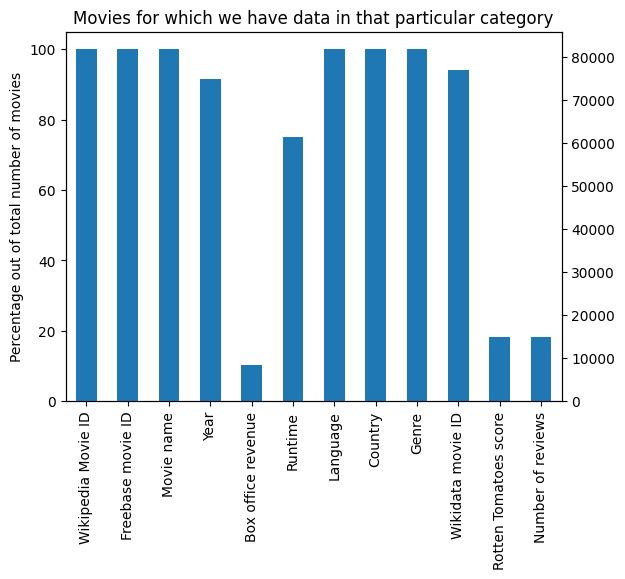

In [24]:
movieDF.count().plot(kind='bar', secondary_y=True)
(movieDF.count()/movieDF.count().max()*100).plot(kind='bar', ylabel='Percentage out of total number of movies', title='Movies for which we have data in that particular category')

In [25]:
print('Number of movies for which we have data in that category\n')
print(characterDF.count())

print('Propotion of movies for which we have data in that category\n')
print(characterDF.count()/characterDF.count().max()*100)

Number of movies for which we have data in that category

Wikipedia Movie ID              450669
Freebase movie ID               450669
Movie date                      440674
Character Name                  192794
DOB                             344524
Gender                          405060
Height                          154824
ethnicity ID                    106058
Actor name                      449441
Actor age at release            292556
Freebase character map          450669
unknown param1                  192804
Freebase wikidata actor page    449854
Ethnicity                       102876
dtype: int64
Propotion of movies for which we have data in that category

Wikipedia Movie ID              100.000000
Freebase movie ID               100.000000
Movie date                       97.782186
Character Name                   42.779512
DOB                              76.447237
Gender                           89.879712
Height                           34.354260
ethnicity ID         

<AxesSubplot: title={'center': 'Proportion of actors for which we have data in that particular category'}, ylabel='Percentage of total number of actors'>

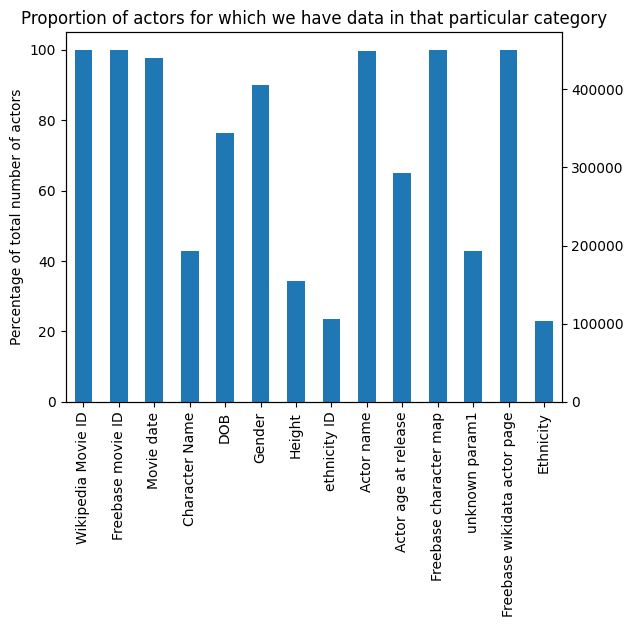

In [26]:
characterDF.count().plot(kind='bar', secondary_y=True)
(characterDF.count()/characterDF.count().max()*100).plot(kind='bar', ylabel='Percentage of total number of actors', title='Proportion of actors for which we have data in that particular category')

### 2: Ethnicity availability

In [129]:
print('We retrieved ethnicity names for %.2f%% of the ethnicity ID\'s' %(100*ethnicityDF.dropna()['Number'].astype(int).sum()/ ethnicityDF['Number'].astype(int).sum()))
print('This means we know the ethnicity name for %d actor entries' %(ethnicityDF.dropna()['Number'].astype(int).sum()))

We retrieved ethnicity names for 97.00% of the ethnicity ID's
This means we know the ethnicity name for 102876 actor entries


### 3: Combined analysis of Movies

<AxesSubplot: >

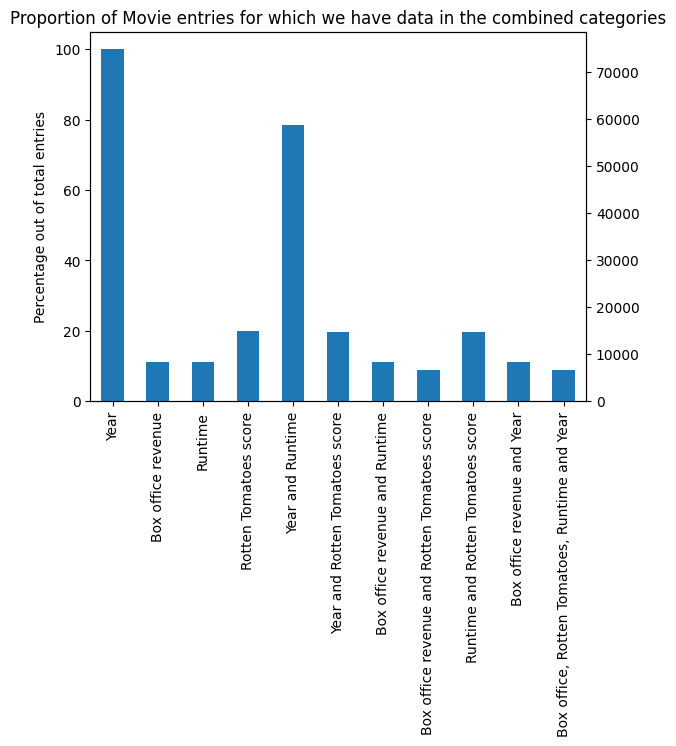

In [122]:
movieStat = pd.DataFrame(data = {'Year' : [movieDF.groupby(by = ['Year']).size().sum()],
                                 'Box office revenue' : [movieDF.groupby(by = ['Box office revenue']).size().sum()],
                                 'Runtime' : [movieDF.groupby(by = ['Box office revenue']).size().sum()],
                                 'Rotten Tomatoes score' : [movieDF.groupby(by = ['Rotten Tomatoes score']).size().sum()],
                                 'Year and Runtime' : [movieDF.groupby(by = ['Year', 'Runtime']).size().sum()],
                                 'Year and Rotten Tomatoes score' : [movieDF.groupby(by = ['Year', 'Rotten Tomatoes score']).size().sum()],
                                 'Box office revenue and Runtime' : [movieDF.groupby(by = ['Box office revenue', 'Runtime']).size().sum()],
                                 'Box office revenue and Rotten Tomatoes score' : [movieDF.groupby(by = ['Box office revenue', 'Rotten Tomatoes score']).size().sum()],
                                 'Runtime and Rotten Tomatoes score' : [movieDF.groupby(by = ['Runtime', 'Rotten Tomatoes score']).size().sum()],
                                 'Box office revenue and Year' : [movieDF.groupby(by = ['Box office revenue', 'Year']).size().sum()],
                                 'Box office, Rotten Tomatoes, Runtime and Year' : [movieDF.groupby(by = ['Box office revenue', 'Rotten Tomatoes score', 'Year', 'Runtime']).size().sum()],
                                 
                                })
movieStat.head()

#characterStat.plot.bar() #two kind of plot
(movieStat.squeeze()/movieStat.squeeze().max()*100).plot(kind='bar')
(movieStat.squeeze()).plot(kind='bar', ylabel='Percentage out of total entries', title='Proportion of Movie entries for which we have data in the combined categories', secondary_y=True)

### 4: Combinatory analysis of character information

<AxesSubplot: >

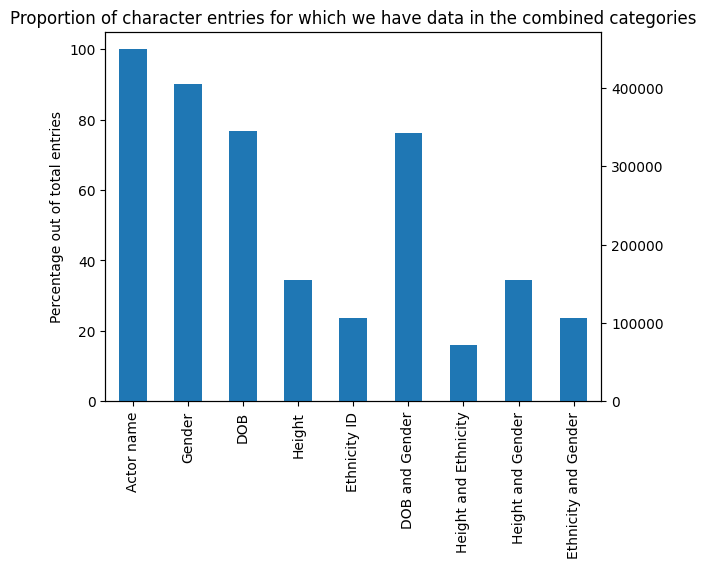

In [123]:
characterStat = pd.DataFrame(data = {'Actor name' : [characterDF.groupby(by = ['Actor name']).size().sum()],
                                     'Gender' : [characterDF.groupby(by = ['Gender']).size().sum()],
                                     'DOB' : [characterDF.groupby(by = ['DOB']).size().sum()],
                                     'Height' : [characterDF.groupby(by = ['Height']).size().sum()],
                                     'Ethnicity ID' : [characterDF.groupby(by = ['ethnicity ID']).size().sum()],
                                     'DOB and Gender' : [characterDF.groupby(by = ['DOB','Gender']).size().sum()],
                                     'Height and Ethnicity' : [characterDF.groupby(by = ['ethnicity ID', 'Height']).size().sum()],
                                     'Height and Gender' : [characterDF.groupby(by = ['Height', 'Gender']).size().sum()],
                                     'Ethnicity and Gender' : [characterDF.groupby(by = ['ethnicity ID', 'Gender']).size().sum()],
                                     })
characterStat.head()

#characterStat.plot.bar() #two kind of plot
(characterStat.squeeze()/characterStat.squeeze().max()*100).plot(kind='bar')
(characterStat.squeeze()).plot(kind='bar', ylabel='Percentage out of total entries', title='Proportion of character entries for which we have data in the combined categories', secondary_y=True)

### 5: Combined analysis of characters and movies

In [30]:
mergedcharacterDF.head()

,Wikipedia Movie ID,Freebase movie ID_x,Movie date,Character Name,DOB,Gender,Height,ethnicity ID,Actor name,Actor age at release,...,Movie name,Year,Box office revenue,Runtime,Language,Country,Genre,Wikidata movie ID,Rotten Tomatoes score,Number of reviews
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,22.0,108.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,22.0,108.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,22.0,108.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,22.0,108.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Q261700,22.0,108.0


<AxesSubplot: >

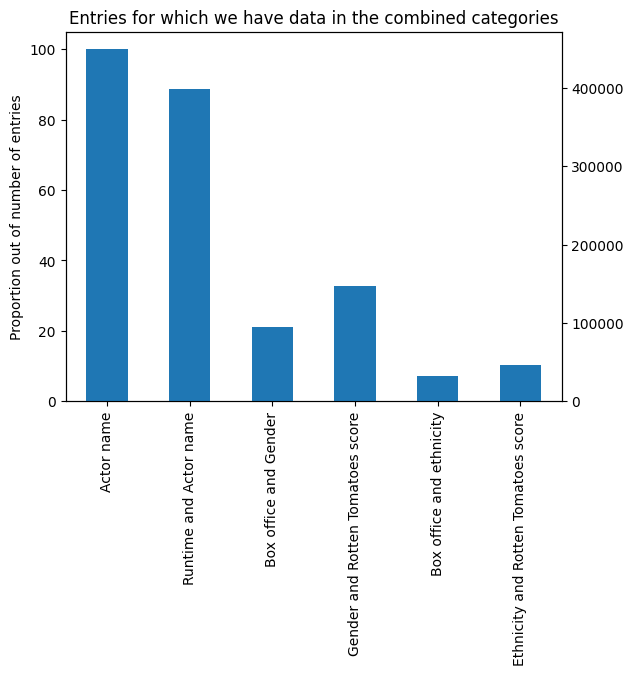

In [124]:
mergedStat = pd.DataFrame(data = {'Actor name' : [mergedcharacterDF.groupby(by = ['Actor name']).size().sum()],
                                  'Runtime and Actor name' : [mergedcharacterDF.groupby(by = ['Runtime', 'Actor name']).size().sum()],
                                  'Box office and Gender' : [mergedcharacterDF.groupby(by = ['Box office revenue','Gender']).size().sum()],
                                  'Gender and Rotten Tomatoes score' : [mergedcharacterDF.groupby(by = ['Gender', 'Rotten Tomatoes score']).size().sum()],
                                  'Box office and ethnicity' : [mergedcharacterDF.groupby(by = ['Box office revenue','ethnicity ID']).size().sum()],
                                  'Ethnicity and Rotten Tomatoes score' : [mergedcharacterDF.groupby(by = ['ethnicity ID', 'Rotten Tomatoes score']).size().sum()],
                                 })
mergedStat.head()

#characterStat.plot.bar() #two kind of plot
(mergedStat.squeeze()/mergedStat.squeeze().max()*100).plot(kind='bar')
(mergedStat.squeeze()).plot(kind='bar', ylabel='Proportion out of number of entries', title='Entries for which we have data in the combined categories', secondary_y=True)

### 6: Temporal analysis

<AxesSubplot: title={'center': 'Number of movies thoughout the years'}, xlabel='Year', ylabel='numbers of movies'>

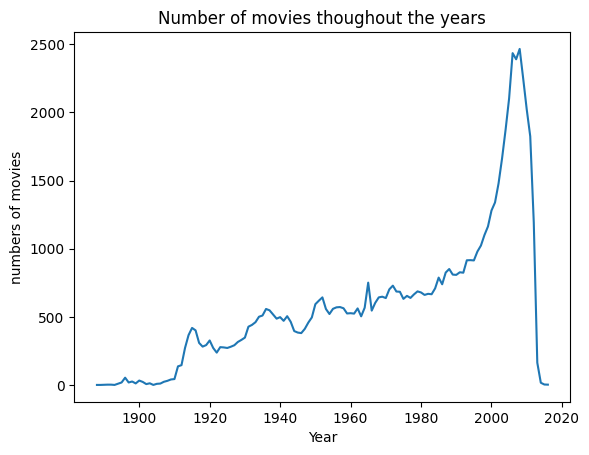

In [32]:
movies_per_year = movieDF.groupby(by=['Year'],  sort=True, dropna=True).size()
movies_per_year.plot(title='Number of movies thoughout the years', ylabel='numbers of movies')

A certain amount of category were omitted for the sake of visibility. Worth to notice, all the categories that we always have, such as _Country, Language, Genre, Freebase movie ID, Wikipedia Movie ID_ were ommited since the curve superpose with the highest one.

<AxesSubplot: title={'center': 'Evolution over time of the amount of entries for the features of the movie dataset'}, xlabel='Year', ylabel='Number of entries'>

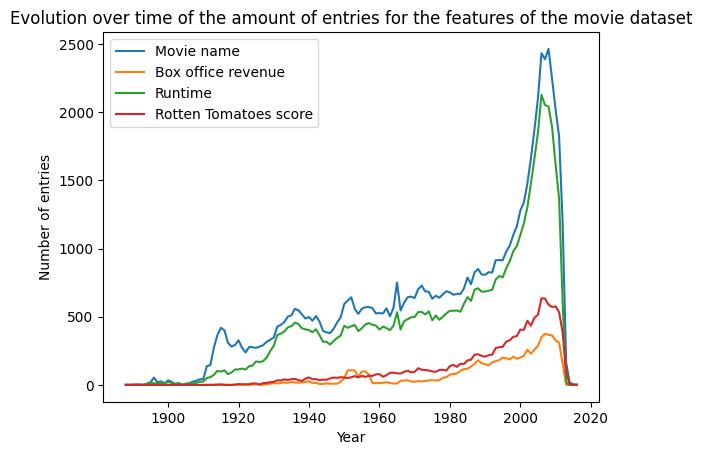

In [33]:
movieDF.groupby(by=['Year']).count().drop(columns=['Freebase movie ID','Wikipedia Movie ID','Wikidata movie ID','Genre','Country','Language','Number of reviews']).plot(title='Evolution over time of the amount of entries for the features of the movie dataset', ylabel='Number of entries')

<AxesSubplot: title={'center': 'Evolution over time of the amount of entries for the features of the character dataset'}, xlabel='Year', ylabel='Number of entries'>

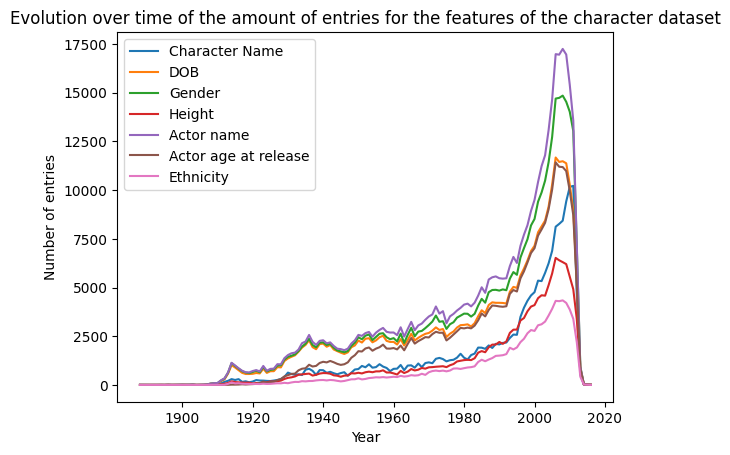

In [34]:
mergedcharacterDF.groupby(by=['Year']).count().drop(columns=['Freebase movie ID_x','Freebase movie ID_y', 'ethnicity ID','Freebase character map','unknown param1','Wikidata movie ID', 'Wikipedia Movie ID', 'Movie date','Genre','Country','Language','Runtime','Number of reviews','Rotten Tomatoes score','Box office revenue','Freebase wikidata actor page', 'Movie name']).plot(title='Evolution over time of the amount of entries for the features of the character dataset', ylabel='Number of entries')

### 7: Rotten Tomatoes score

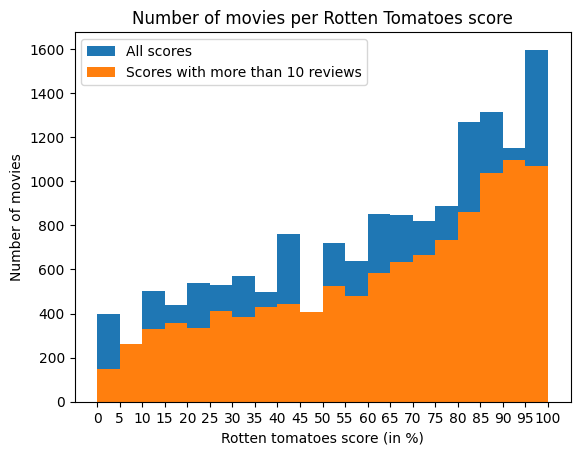

In [35]:
plt.hist(movieDF[(~movieDF['Rotten Tomatoes score'].isnull() )]['Rotten Tomatoes score'], bins = 20, label='All scores')
plt.hist(movieDF[movieDF['Number of reviews']>10]['Rotten Tomatoes score'], bins = 20,label='Scores with more than 10 reviews')
plt.xlabel('Rotten tomatoes score (in %)')
plt.ylabel('Number of movies')
plt.title('Number of movies per Rotten Tomatoes score')
plt.legend(loc='upper left')
plt.grid(False)
plt.xticks(np.arange(0,105,5))
plt.show()

In [36]:
print('There is', len(movieDF),' movies in the original dataset.')
print('Of those,',len(movieDF[(~movieDF['Rotten Tomatoes score'].isnull() )]),'have a Rotten Tomatoes score.')
print('Furthermore,', len(movieDF[movieDF['Number of reviews']>=10]), 'of those movies were reviewed by at least 10 critics.')
print('This represents',len(movieDF[movieDF['Number of reviews']>=10])/len(movieDF)*100,'%% of the data.')

There is 81741  movies in the original dataset.
Of those, 14990 have a Rotten Tomatoes score.
Furthermore, 11619 of those movies were reviewed by at least 10 critics.
This represents 14.214408925753293 %% of the data.


### 8: Simple ethnicity display for Men in Black and Pulp fiction

In [119]:
((mergedcharacterDF.set_index('Wikidata movie ID')).loc['Q51416']).loc[:,['Actor name','Ethnicity']].dropna()

,Actor name,Ethnicity
Wikidata movie ID,,
Q51416,David Cross,British Americans
Q51416,Danny DeVito,Italian Americans
Q51416,Steven Spielberg,Jewish people
Q51416,Sylvester Stallone,Italian Americans
Q51416,George Lucas,white people
Q51416,Al Roker,Bahamian Americans
Q51416,Tony Shalhoub,Arab Americans
Q51416,Will Smith,African Americans


In [118]:
#Ethnicity for actor's in pulp fiction
((mergedcharacterDF.set_index('Wikidata movie ID')).loc['Q104123']).loc[:,['Actor name','Ethnicity']].dropna()

,Actor name,Ethnicity
Wikidata movie ID,,
Q104123,Rosanna Arquette,American Jews
Q104123,John Travolta,Italian Americans
Q104123,Samuel L. Jackson,African Americans
Q104123,Tim Roth,English people
Q104123,Ving Rhames,African Americans
Q104123,Phil LaMarr,African Americans
Q104123,Maria de Medeiros,Portuguese
Q104123,Uma Thurman,Swedish Americans
Q104123,Paul Calderon,Stateside Puerto Ricans


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=39bd4864-bd64-4acf-aecd-be9e263fab94' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>